# XStoryCloze evaluation

In [1]:
import pandas as pd
import math

langs_xstory = ["en", "ru", "zh", "es", "ar", "hi", "id", "te", "sw", "eu", "my"]

def get_accuracy(results_xstory_df):
    """Compute accuracy.

    Args:
        results_xstory_df (dataframe): dataframe

    Returns:
        accuracy (dict): accuracy
    """
    accuracy = {}
    for lang in langs_xstory:
        compare = results_xstory_df["label"] == results_xstory_df[lang]
        acc = list(compare).count(True) / len(list(compare)) * 100
        accuracy[lang] = round(acc, 1)
    accuracy["avg"] = round(sum(accuracy.values()) / len(accuracy), 1)
    return accuracy

def get_perplexity(results_xstory_df):
    """Compute perplexity.

    Args:
        results_xstory_df (dataframe): dataframe

    Returns:
        perplexity_correct (dict): perplexity for correct answers
        perplexity_incorrect (dict): perplexity for incorrect answers
    """
    perplexity_correct = {}
    perplexity_incorrect = {}

    for lang in langs_xstory:
        correct = []
        incorrect = []
        for _, row in results_xstory_df.iterrows():
            if row["label"] == 1:
                correct.append(-row[lang + "_lprob1"])
                incorrect.append(-row[lang + "_lprob2"])
            else:
                correct.append(-row[lang + "_lprob2"])
                incorrect.append(-row[lang + "_lprob1"])
        perplexity_correct[lang] = round(math.exp(sum(correct) / len(correct)), 2)
        perplexity_incorrect[lang] = round(math.exp(sum(incorrect) / len(incorrect)), 2)
    perplexity_correct["avg"] = round(
        sum(perplexity_correct.values()) / len(perplexity_correct), 2
    )
    perplexity_incorrect["avg"] = round(
        sum(perplexity_incorrect.values()) / len(perplexity_incorrect), 2
    )
    return perplexity_correct, perplexity_incorrect


def compute_metrics(model_name):
    """Compute metrics and save them."""
    results_xstory_df = pd.read_csv(
        f"../results/xstory_cloze_{model_name}.tsv", delimiter="\t"
    )
    accuracy = get_accuracy(results_xstory_df)
    perplexity_correct, perplexity_incorrect = get_perplexity(results_xstory_df)
    metrics_df = pd.DataFrame(
        {
            "acc": accuracy,
            "ppl_cor": perplexity_correct,
            "ppl_inc": perplexity_incorrect,
        }
    )

    metrics_df.to_csv(
        f"../results/xstory_cloze_{model_name}_metrics.tsv",
        sep="\t",
        index_label="lang",
    )

def get_dfs(model_names):
    acc_df = pd.DataFrame()
    ppl_cor_df = pd.DataFrame()
    ppl_inc_df = pd.DataFrame()

    for model_name in model_names:
        name = model_name.split("/")[-1]
        compute_metrics(name)
        metrics_df = pd.read_csv(
            f"../results/xstory_cloze_{name}_metrics.tsv", delimiter="\t"
        )
        acc_df["lang"] = metrics_df["lang"]
        ppl_cor_df["lang"] = metrics_df["lang"]
        ppl_inc_df["lang"] = metrics_df["lang"]
        acc_df[name] = metrics_df["acc"]
        ppl_cor_df[name] = metrics_df["ppl_cor"]
        ppl_inc_df[name] = metrics_df["ppl_inc"]

    return acc_df, ppl_cor_df, ppl_inc_df


import matplotlib.pyplot as plt


def plot_df(df, title):
    df.plot.bar()
    plt.title(title)
    plt.xticks(list(range(12)), df["lang"], rotation="vertical")
    plt.show()


## mGPT

In [2]:
metrics_df = pd.read_csv(f"../results/xstory_cloze_mGPT_metrics.tsv", delimiter="\t")
metrics_df

,lang,acc,ppl_cor,ppl_inc
0,en,63.2,20.67,21.80
1,ru,61.3,12.86,13.30
2,zh,57.0,17.21,17.63
3,es,58.8,17.40,18.01
4,ar,53.3,24.25,24.61
5,hi,56.5,4.42,4.48
6,id,58.8,19.37,20.06
7,te,58.2,3.57,3.63
8,sw,57.8,12.47,12.82
9,eu,55.9,16.91,17.28


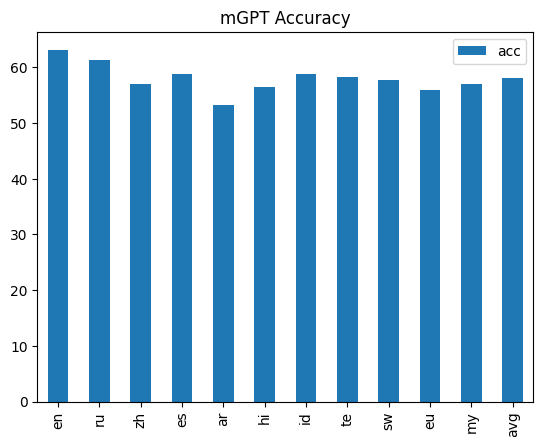

In [3]:
plot_df(metrics_df[["lang", "acc"]], "mGPT Accuracy")


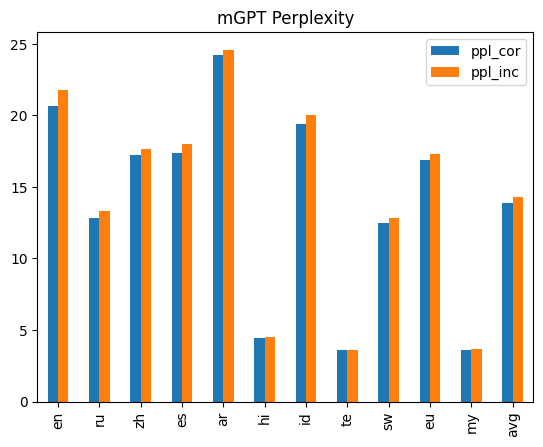

In [4]:
plot_df(metrics_df[["lang", "ppl_cor", "ppl_inc"]], "mGPT Perplexity")


## XGLM

In [5]:
xglm_model_names = [
    "facebook/xglm-564M",
    "facebook/xglm-1.7B",
    "facebook/xglm-2.9B",
    "facebook/xglm-4.5B",
    "facebook/xglm-7.5B",
]
xglm_model_sizes = [0.6, 1.7, 2.9, 4.5, 7.5]
xglm_names = [name.split("/")[-1] for name in xglm_model_names]
acc_df, ppl_cor_df, ppl_inc_df = get_dfs(xglm_model_names)


In [6]:
display(acc_df)
display(ppl_cor_df)
display(ppl_inc_df)


,lang,xglm-564M,xglm-1.7B,xglm-2.9B,xglm-4.5B,xglm-7.5B
0,en,61.3,66.6,69.6,72.1,73.7
1,ru,59.5,62.8,67.2,66.8,69.0
2,zh,56.3,60.2,64.1,64.4,65.9
3,es,56.5,60.6,64.6,66.4,66.7
4,ar,53.9,55.6,57.7,57.7,58.5
5,hi,54.2,56.8,59.4,57.1,59.5
6,id,56.8,61.5,65.5,65.6,68.0
7,te,56.9,58.4,59.4,58.7,60.6
8,sw,56.4,60.8,60.8,60.1,63.3
9,eu,55.1,57.5,58.4,55.3,61.7


,lang,xglm-564M,xglm-1.7B,xglm-2.9B,xglm-4.5B,xglm-7.5B
0,en,21.41,17.18,15.57,14.67,14.43
1,ru,21.55,16.51,15.07,14.10,13.86
2,zh,33.26,25.65,22.72,21.26,20.70
3,es,24.74,18.75,16.70,15.69,15.10
4,ar,44.25,31.90,26.17,27.32,23.48
5,hi,23.14,18.21,16.33,20.63,15.31
6,id,42.47,31.93,28.09,28.64,25.71
7,te,29.10,24.68,20.60,26.38,18.81
8,sw,47.24,33.23,28.51,46.27,25.16
9,eu,34.55,23.12,20.18,104.26,18.94


,lang,xglm-564M,xglm-1.7B,xglm-2.9B,xglm-4.5B,xglm-7.5B
0,en,22.50,18.41,16.91,16.04,15.83
1,ru,22.32,17.34,16.02,15.01,14.83
2,zh,34.08,26.61,23.86,22.41,21.92
3,es,25.50,19.58,17.64,16.65,16.10
4,ar,44.79,32.59,26.96,28.11,24.31
5,hi,23.48,18.64,16.85,21.24,15.84
6,id,44.09,33.73,30.13,30.72,27.88
7,te,29.89,25.52,21.42,27.34,19.62
8,sw,48.73,34.70,29.92,48.24,26.57
9,eu,35.48,23.84,20.93,107.33,19.77


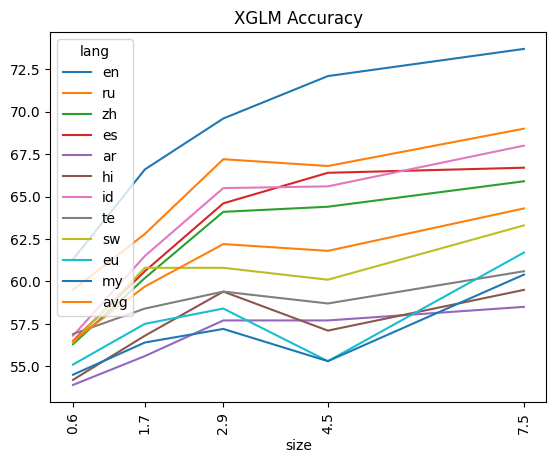

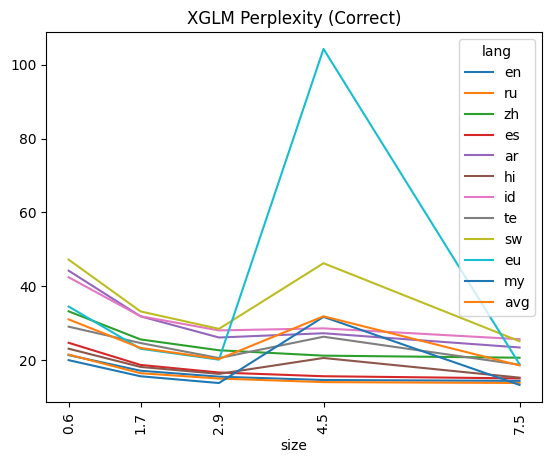

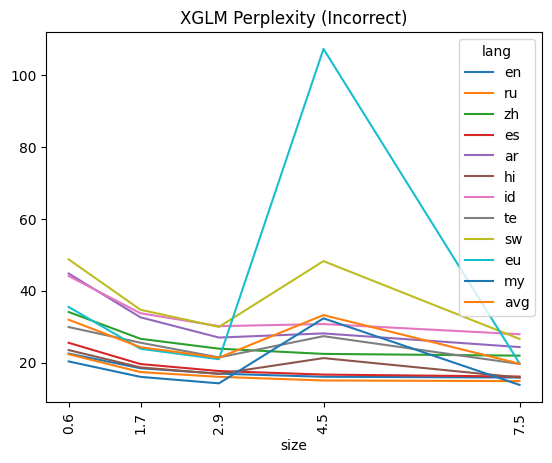

In [7]:
# create a function to create the previous plot for any model
def plot_size_df(df, model_sizes, model_names, title):
    dft = df.set_index("lang").T
    dft["size"] = model_sizes
    dft.plot(x="size")
    plt.title(title)
    plt.xticks(model_sizes, model_sizes, rotation="vertical")


plot_size_df(acc_df, xglm_model_sizes, xglm_names, "XGLM Accuracy")
plot_size_df(ppl_cor_df, xglm_model_sizes, xglm_names, "XGLM Perplexity (Correct)")
plot_size_df(ppl_inc_df, xglm_model_sizes, xglm_names, "XGLM Perplexity (Incorrect)")


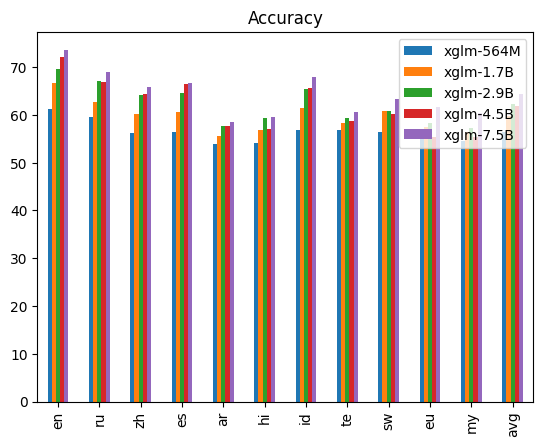

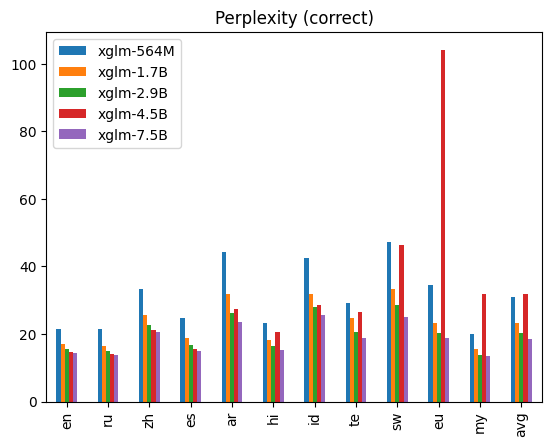

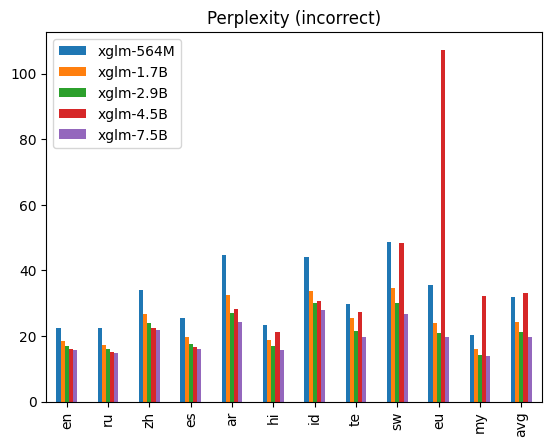

In [8]:
plot_df(acc_df, "Accuracy")
plot_df(ppl_cor_df, "Perplexity (correct)")
plot_df(ppl_inc_df, "Perplexity (incorrect)")


## BLOOM

In [9]:
bloom_model_names = [
    "bigscience/bloom-560m",
    "bigscience/bloom-1b1",
    "bigscience/bloom-1b7",
    "bigscience/bloom-3b",
    "bigscience/bloom-7b1",
]
bloom_names = [name.split("/")[-1] for name in bloom_model_names]
bloom_model_sizes = [0.6, 1.1, 1.7, 3.0, 7.1]
acc_df, ppl_cor_df, ppl_inc_df = get_dfs(bloom_model_names)


In [10]:
display(acc_df)
display(ppl_cor_df)
display(ppl_inc_df)


,lang,bloom-560m,bloom-1b1,bloom-1b7,bloom-3b,bloom-7b1
0,en,64.1,67.4,70.0,72.1,74.9
1,ru,55.3,54.3,56.7,57.7,59.2
2,zh,58.8,63.3,65.0,67.3,69.4
3,es,58.7,61.3,64.3,67.0,70.1
4,ar,52.7,56.5,56.0,59.6,62.5
5,hi,54.3,56.7,57.8,58.6,62.7
6,id,56.9,61.8,62.9,66.8,69.4
7,te,55.2,55.3,56.0,58.5,57.5
8,sw,52.7,53.7,57.7,58.0,59.2
9,eu,53.8,53.8,55.7,57.2,59.0


,lang,bloom-560m,bloom-1b1,bloom-1b7,bloom-3b,bloom-7b1
0,en,25.17,21.03,18.82,16.70,14.87
1,ru,27.34,22.23,17.14,14.61,11.75
2,zh,50.50,41.78,36.88,33.22,29.73
3,es,23.78,20.01,17.83,16.09,14.66
4,ar,61.01,47.04,40.49,35.01,30.16
5,hi,36.25,30.39,25.89,23.60,20.80
6,id,421.08,49.98,42.55,35.84,31.89
7,te,166.78,115.38,64.08,63.15,50.55
8,sw,513.69,356.80,175.12,131.60,88.72
9,eu,116.24,88.00,60.89,50.50,41.14


,lang,bloom-560m,bloom-1b1,bloom-1b7,bloom-3b,bloom-7b1
0,en,26.79,22.58,20.45,18.33,16.53
1,ru,28.00,22.70,17.57,15.02,12.14
2,zh,53.13,44.53,39.61,36.03,32.65
3,es,24.75,20.99,18.92,17.24,15.88
4,ar,62.20,48.42,42.00,36.57,31.93
5,hi,37.08,31.29,26.75,24.59,21.81
6,id,443.79,52.86,45.52,38.68,34.95
7,te,171.31,118.89,66.10,65.51,52.52
8,sw,529.58,365.86,182.30,137.75,93.63
9,eu,118.98,90.22,62.87,52.24,43.03


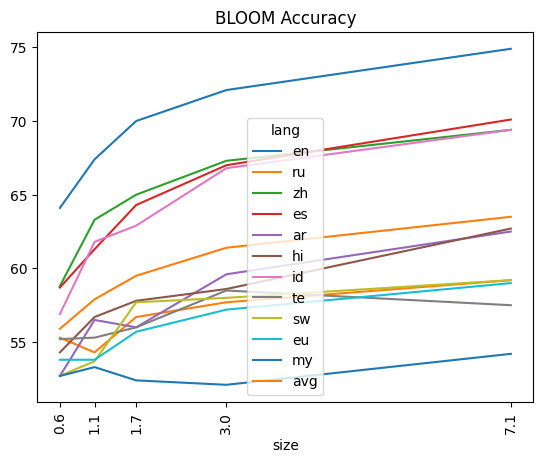

In [11]:
plot_size_df(acc_df, bloom_model_sizes, bloom_names, "BLOOM Accuracy")


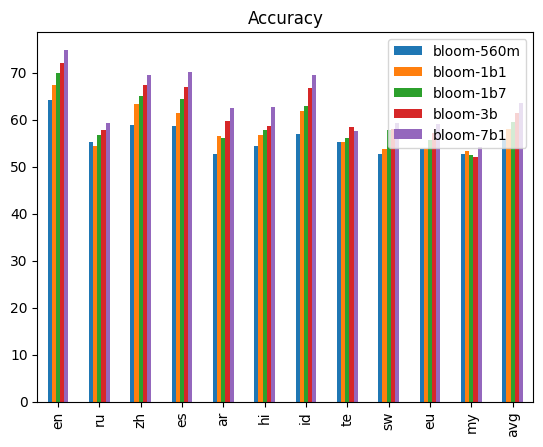

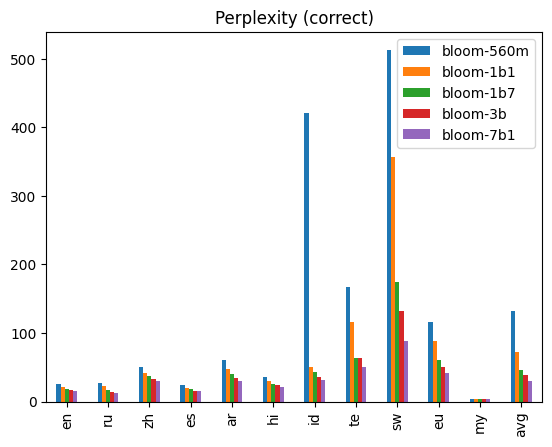

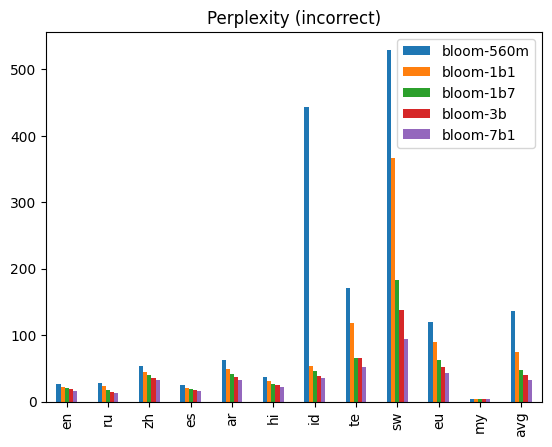

In [12]:
plot_df(acc_df, "Accuracy")
plot_df(ppl_cor_df, "Perplexity (correct)")
plot_df(ppl_inc_df, "Perplexity (incorrect)")


## BLOOMZ

In [13]:
bloomz_model_names = [
    "bigscience/bloomz-560m",
    "bigscience/bloomz-1b1",
    "bigscience/bloomz-1b7",
    "bigscience/bloomz-3b",
    "bigscience/bloomz-7b1",
    "bigscience/bloomz-7b1-mt",
    "bigscience/bloomz-7b1-p3",
]
bloomz_names = [name.split("/")[-1] for name in bloomz_model_names]
bloomz_model_sizes = [0.6, 1.1, 1.7, 3.0, 7.1, 7.1, 7.1]
acc_df, ppl_cor_df, ppl_inc_df = get_dfs(bloomz_model_names)


In [14]:
display(acc_df)
display(ppl_cor_df)
display(ppl_inc_df)


,lang,bloomz-560m,bloomz-1b1,bloomz-1b7,bloomz-3b,bloomz-7b1,bloomz-7b1-mt,bloomz-7b1-p3
0,en,66.0,68.8,72.4,74.4,78.0,78.4,78.1
1,ru,54.9,53.5,55.1,56.2,56.8,57.0,59.1
2,zh,62.3,64.3,63.1,62.9,66.8,67.6,73.2
3,es,60.0,62.3,60.4,58.3,68.0,67.5,69.2
4,ar,55.2,58.1,56.3,56.3,60.8,62.1,66.5
5,hi,54.6,57.4,55.1,55.3,59.6,57.8,65.8
6,id,50.6,62.9,57.9,58.2,61.5,61.2,67.5
7,te,52.5,55.0,52.0,52.8,55.3,54.5,59.2
8,sw,53.4,53.5,52.4,53.8,54.9,56.2,59.2
9,eu,47.1,52.0,47.2,45.9,52.9,51.1,59.1


,lang,bloomz-560m,bloomz-1b1,bloomz-1b7,bloomz-3b,bloomz-7b1,bloomz-7b1-mt,bloomz-7b1-p3
0,en,24.69,20.04,18.57,16.90,15.18,15.02,15.97
1,ru,336.42,29.06,275.05,71.41,35.33,34.19,14.36
2,zh,55.72,39.26,201.04,1328.52,229.26,185.35,71.93
3,es,30.23,19.97,68.04,111.60,33.56,45.88,21.92
4,ar,457.17,46.39,323.19,615.79,110.64,106.18,58.39
5,hi,645.07,32.66,4906.12,4065.63,469.22,1616.87,46.36
6,id,27358560.60,64.19,3687.49,3650.53,2574.75,4844.56,66.11
7,te,5606.46,97.41,28257.47,27149.30,3633.10,8788.37,76.16
8,sw,1426.43,349.50,1806.27,3225.77,2088.35,2541.11,166.68
9,eu,6841.67,288.67,28747.34,22186.82,4138.25,6434.85,85.29


,lang,bloomz-560m,bloomz-1b1,bloomz-1b7,bloomz-3b,bloomz-7b1,bloomz-7b1-mt,bloomz-7b1-p3
0,en,26.46,21.74,20.43,18.80,17.19,17.04,18.37
1,ru,346.63,29.61,283.78,73.54,36.61,35.47,14.86
2,zh,59.45,42.26,219.60,1458.29,257.09,208.04,82.36
3,es,31.57,21.09,72.31,117.73,36.59,50.18,24.20
4,ar,478.23,48.25,337.64,635.47,117.52,113.56,63.32
5,hi,661.11,33.87,5117.14,4222.96,496.04,1710.25,49.56
6,id,23056264.00,68.18,3920.80,3851.31,2809.18,5328.30,73.53
7,te,5690.15,99.97,28922.91,27755.74,3784.70,9069.93,80.02
8,sw,1459.68,356.69,1848.71,3316.85,2175.87,2663.81,176.53
9,eu,6689.80,293.84,28074.24,21626.92,4213.08,6514.98,90.57


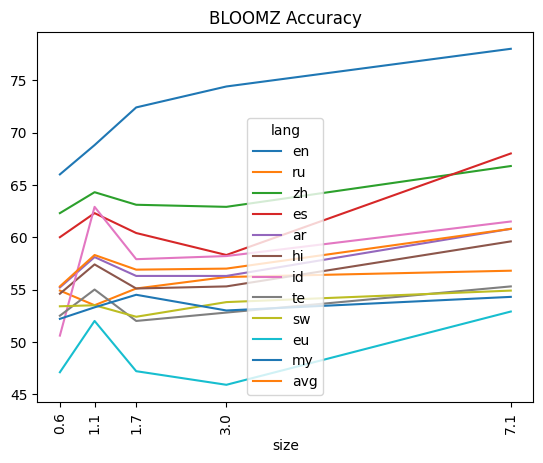

In [15]:
plot_size_df(
    acc_df[
        ["lang", "bloomz-560m", "bloomz-1b1", "bloomz-1b7", "bloomz-3b", "bloomz-7b1"]
    ],
    bloomz_model_sizes[:-2],
    bloomz_names[:-2],
    "BLOOMZ Accuracy",
)


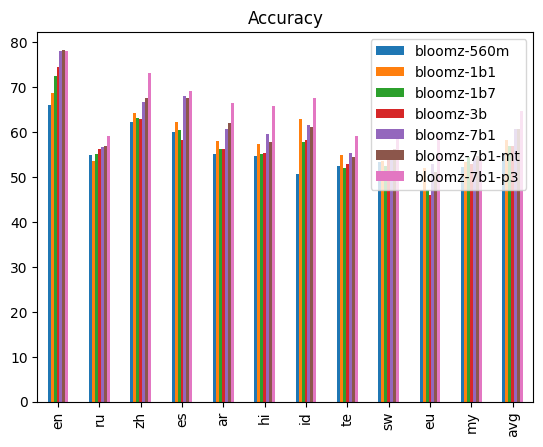

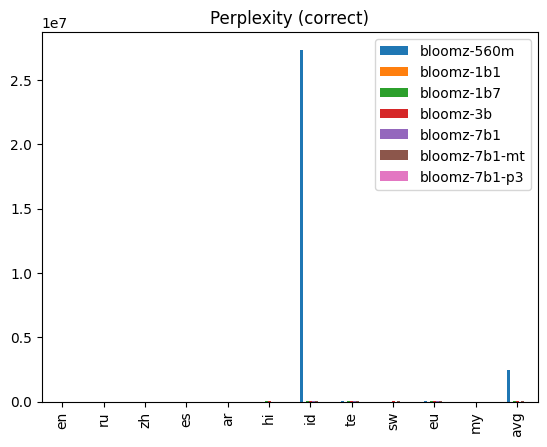

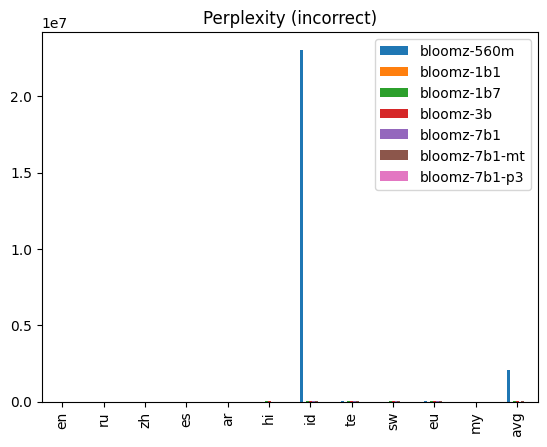

In [16]:
plot_df(acc_df, "Accuracy")
plot_df(ppl_cor_df, "Perplexity (correct)")
plot_df(ppl_inc_df, "Perplexity (incorrect)")
